# Introduction

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# imports
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# use this if you want to render static plotly images to display them on Github
# otherwise, comment this section out to enjoy interactive plotly plots
import plotly.io as pio
pio.renderers.default = "svg"

from ts import data
from ts import viz
from ts import processing
from ts import dsp

np.set_printoptions(precision=2, suppress=1)

# Data

In [3]:
from datetime import datetime

global_temp_raw = data.load_globaltemp(mode='monthly')
global_temp_raw.Date = pd.to_datetime(global_temp_raw.Date)
date = datetime(1995, 1, 1)
global_temp = (global_temp_raw
               .query('Source=="GCAG"')
               .filter(['Date', 'Mean'])
               .query('Date > @date')
               .set_index('Date')
               .rename(columns={'Mean':'temp'})
              )

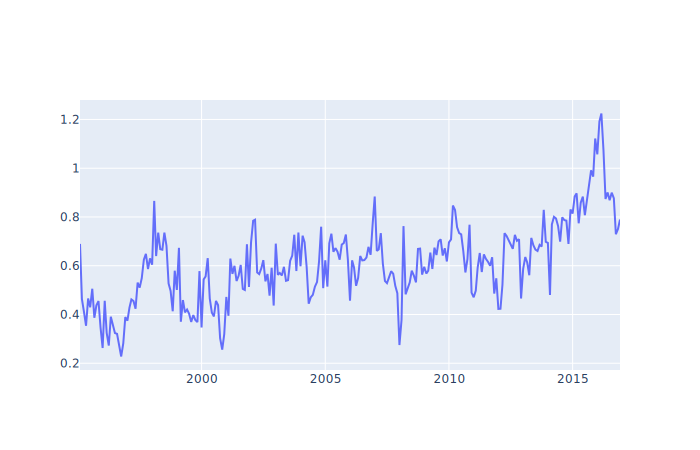

In [4]:
viz.plot_basic_timeseries(index=global_temp.index, timeseries=global_temp.temp)

**Data must be stationary before running a regression**

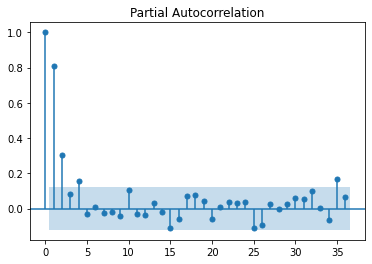

In [5]:
viz.plot_pacf(global_temp.temp + abs(global_temp.temp.min()), lags=36);

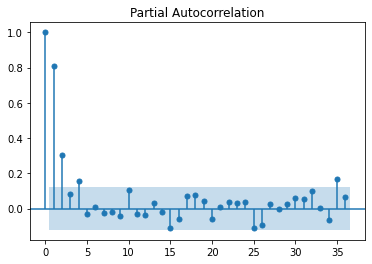

In [6]:
d = global_temp.temp + abs(global_temp.temp.min())
viz.plot_pacf(d, lags=36);

Here is a function that splits time series data into training and testing datasets

In [7]:
def load_global_temp_data(df, test_at):
    # sort by date & use a numeric index
    data = df.sort_values('Date').reset_index()

    # split by datet
    train_data = data.query('Date <= @test_at')
    test_data = data.query('Date > @test_at')

    # drop date column
    train_data = train_data[['temp']]
    test_data = test_data[['temp']]

    X_train, y_train = train_data.index.values, train_data.temp.values
    X_test, y_test = test_data.index.values, test_data.temp.values
    
    return X_train, y_train, X_test, y_test

# Gaussian Processes

In this section, we explore how we can use Gaussian Processes for time series forecasting

## Kernel Design

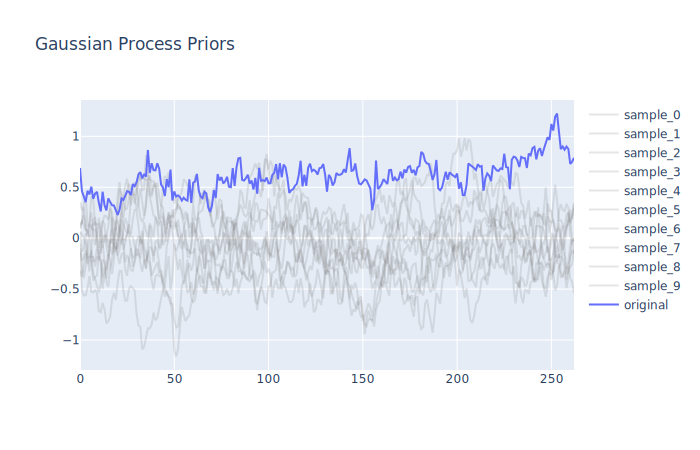

In [8]:
from sklearn.gaussian_process.kernels import (
    WhiteKernel, 
    ExpSineSquared, 
    ConstantKernel, 
    RBF,
    Matern,
    DotProduct,
    RationalQuadratic
)
from sklearn.gaussian_process import GaussianProcessRegressor

# load data
test_at = datetime(2008, 1, 1)
X_train, y_train, X_test, y_test = load_global_temp_data(global_temp, test_at=test_at) 

# Design Kernel
kernel  =  (
    # a long term, smooth rising trend explained by an RBF kernel with a large length-scale
    0.7*RBF(length_scale=10) +
    # smaller, medium term irregularities are to be explained by a RationalQuadratic kernel component
    0.15*RationalQuadratic(alpha=17.7, length_scale=0.957) +
    0.15*ExpSineSquared(length_scale=10, periodicity=12)
)

# Define GP
gp = GaussianProcessRegressor(kernel=0.1*kernel, normalize_y=True)

# plot priors
X = np.append(X_train, X_test)
y = np.append(y_train, y_test)
priors_fig = viz.plot_gp_priors(gp, X=X, y=y, nb_samples=10)

priors_fig.show()

## Gaussian Process Training

In [9]:
# Fit GP
gp.fit(X_train.reshape(-1, 1), y_train)

# Predict
y_train_pred, y_train_std = gp.predict(X_train.reshape(-1, 1), return_std=True)

y_test_pred = []
y_test_std = []
window = 1
X_train_expand = X_train.copy()
y_train_expand = y_train.copy()

for step in range(0, X_test.shape[0], window):
    
    # append point to training data
    start = step
    end = step + window if step + window <= X_test.shape[0] else X_test.shape[0]
    X_train_expand = np.append(X_train_expand, X_test[start: end])
    y_train_expand = np.append(y_train_expand, y_test[start: end])
    
    # predict on the last window-size indices
    window = window if step + window <= X_test.shape[0] else (X_test.shape[0] - step)
    prediction, std = gp.predict(X_train_expand[-window:].reshape(-1, 1), return_std=True)
    y_test_pred.append(prediction)
    y_test_std.append(std)
    
    # retrain
    gp.fit(X_train_expand.reshape(-1, 1), y_train_expand)

# flatten
y_test_pred = np.hstack(np.array(y_test_pred))
y_test_std = np.hstack(np.array(y_test_std))

y_std = np.append(y_train_std, y_test_std)

## Visualizing the Forecast 

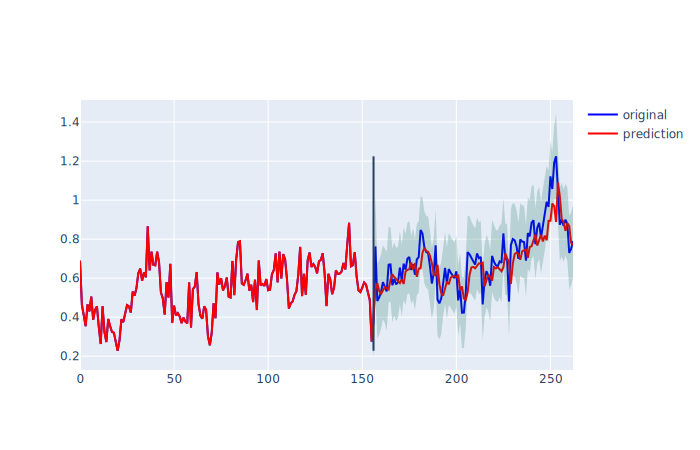

In [10]:
# Plot Results
ts_plot = viz.plot_gp_ts(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test, 
    y_train_pred=y_train_pred,
    y_test_pred=y_test_pred,
    y_std=y_std
)

ts_plot.show()

## Measuring Performance

In [11]:
from sklearn.metrics import mean_squared_error

gp_rmse = mean_squared_error(y_test_pred, y_test)

# persistence
baseline_rmse = mean_squared_error(y_test[1:], y_test[:-1])

print(f'Baseline RMSE: {baseline_rmse:.3F}')
print(f'GP RMSE: {gp_rmse:.3F}')

Baseline RMSE: 0.010
GP RMSE: 0.009
